In [75]:
# !git clone https://github.com/DenisPerez/NN_Tests_DG.git
# %cd NN_Tests_DG
# %ls

## CIFAR 10 notebook for TEG


## Importamos las librerias necesarias

In [76]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch stuff
import torch
torch.manual_seed(0) # => importante para replicar los experimentos. Setea la semilla para la generacion de numeros aleatorios
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import seaborn as sns

from classes import CyclicLRGiselt_Denis
import random

In [77]:
def plot_confusion_matrix(cm):
    labels = np.arange(len(cm))
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', square=True, xticklabels=labels, yticklabels=labels, ax=ax, cbar=True)

    # Formatear los números en el eje x e y sin notación científica
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()

def validate_confusion_matrix(cm, num_samples):
    # Verificar si la suma de cada fila de la matriz de confusión es igual a num_samples
    for i, num_sample in enumerate(num_samples):
        assert cm[i,:].sum() == num_sample, f"La suma de la fila {i} no es igual a {num_samples}, el valor es {cm[i,:].sum()}"
    
    print("La matriz de confusión es válida")

## Usamos la GPU en caso de estar disponible


In [78]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


##  Datasets y Dataloaders

In [79]:
PATH = './Dataset/cifar-10' # Path en donde queramos colocar le Dataset
TRAIN_SIZE = 50000 # Tamano del set de entrenamiento
VAL_SIZE = 5000 # Tamano del set de validacion
TEST_SIZE = 5000 #Tamano del set de pruebas
MINIBATCH_SIZE = 512 #Tamano del minibatch

#T.Compose hace que al generar cada minibatch se aplique la serie de transformaciones descritas
transform_cifar10_train = T.Compose([
                T.RandomHorizontalFlip(p=0.3), #Con probabilidad de 0.3 (30%) hara un flip horizontal sobre el set de entrenamiento
                T.ColorJitter(brightness=0.1, contrast=0.1, hue = 0.05), # Realice ajustes de brillo, contraste y ajuste de color
                T.RandomApply([T.RandomRotation(10), #Rotacion de 10 grados
                               T.Resize(40), #Hacemos aumento de la imagen a 40x40 pixeles
                               T.CenterCrop(32)], #Recortamos los 32 pixeles del centro de la imagens
                               p = 0.1), #Probabilidad de realizar esto
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])
transform_cifar10_test = T.Compose([
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(PATH, 
                                train=True, 
                                download=True,
                                transform=transform_cifar10_train) #Descargamos el set de entrenamiento en caso de no tenerlo
train_loader = DataLoader(cifar10_train, 
                          batch_size=MINIBATCH_SIZE, 
                          shuffle = True) #Creamos el dataloader. El dataloader permite tener un iterable (x,y) sobre el set de CIFAR 10

# Validation and test sets
test_dataset = datasets.CIFAR10(PATH, 
                                train=False, 
                                download=True, 
                                transform=transform_cifar10_test) #Descargamos datos de prueba
val_dataset, test_dataset = random_split(test_dataset, [VAL_SIZE, TEST_SIZE]) #Hacemos un spit random para validacion y test

val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [80]:
class_count = [0] * 10 # Inicializamos una lista con 10 elementos en 0, una para cada clase

for _, labels in test_loader:
    for label in labels:
        class_count[label] += 1

print(f"Cantidad de elementos en cada clase: {class_count}")

Cantidad de elementos en cada clase: [501, 501, 522, 489, 522, 512, 486, 499, 485, 483]


In [81]:
for i,(x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([512, 3, 32, 32]) torch.Size([512])
1 torch.Size([512, 3, 32, 32]) torch.Size([512])
2 torch.Size([512, 3, 32, 32]) torch.Size([512])
3 torch.Size([512, 3, 32, 32]) torch.Size([512])
4 torch.Size([512, 3, 32, 32]) torch.Size([512])
5 torch.Size([512, 3, 32, 32]) torch.Size([512])
6 torch.Size([512, 3, 32, 32]) torch.Size([512])
7 torch.Size([512, 3, 32, 32]) torch.Size([512])
8 torch.Size([512, 3, 32, 32]) torch.Size([512])
9 torch.Size([392, 3, 32, 32]) torch.Size([392])


### Mostrar datos

La imagen muestreada representa un: cat


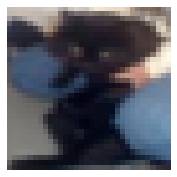

In [82]:
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

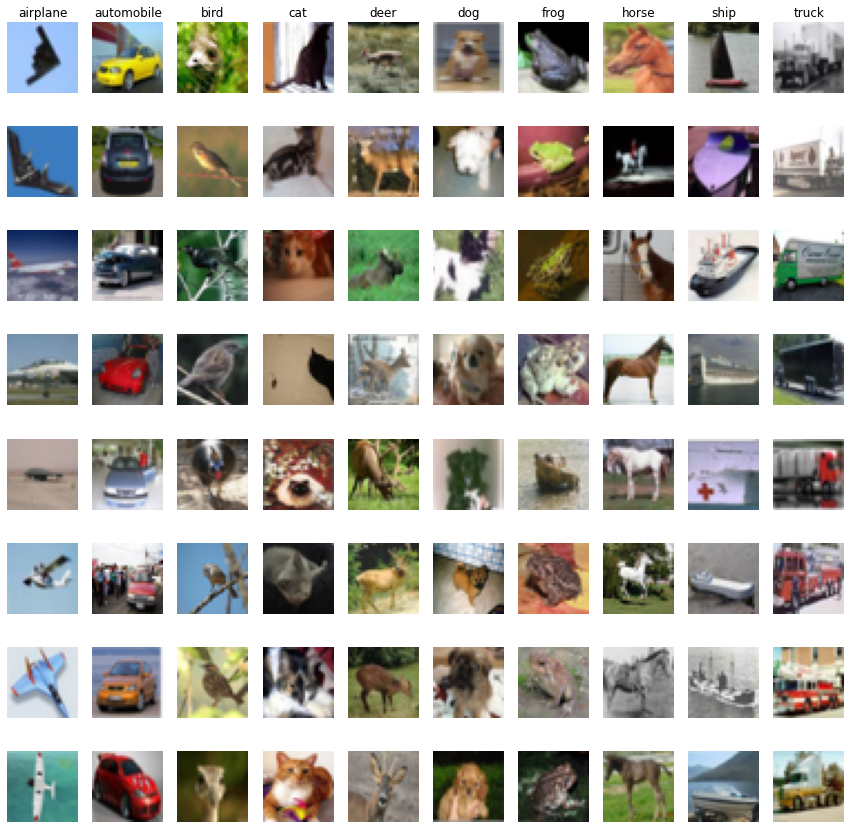

In [83]:
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(train_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 


#### Accuracy

In [84]:
len(val_loader)

10

In [85]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader
    
    Returns:
    
    '''
    correct = 0
    total = 0
    cost = 0
    y_true = []
    y_pred = []

    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)

            y_true[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE] = y.cpu().numpy()
            y_pred[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE] = pred.cpu().numpy()

        y_true = np.array(y_true).reshape(total, 1)
        y_pred = np.array(y_pred).reshape(total, 1)

        cm = confusion_matrix(y_true, y_pred)
        
        #Aca agregue retornar el costo tambien para poder saber la funcion de costo para el set de test o validacion
        return cost/len(val_loader), float(correct)/total, cm

#### Buscar learning rate

In [86]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Loop de Entrenamiento

In [87]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    i = 0
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    val_acc = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        if(val_acc >= 0.95):
            break;
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_acc = float(train_correct_num)/train_total  
            train_acc_history.append(train_acc)
            train_acc = float(train_correct_num)/train_total
            train_cost_acum += cost.item()
            train_cost = train_cost_acum/len(train_loader)
            train_loss_history.append(cost.item())
        #if using scheduler
        if scheduler: 
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimiser.param_groups[0]["lr"]
        val_cost, val_acc, _ = accuracy(model, val_loader)

        val_loss_history.append(val_cost)
        val_acc_history.append(val_acc)
        lrs.append(lr)
        i+=i
        
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {lr:.6f}')
        
    return val_acc_history,val_loss_history, lrs, i

# ResNet56
https://arxiv.org/pdf/1512.03385.pdf

In [88]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)

In [89]:
class residual_block(nn.Module):
    '''

    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #for changing activation map sizes
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, 
                                                    out_channel, 
                                                    kernel_size=1,
                                                    stride=stride),
                                         nn.BatchNorm2d(out_channel)
                                         )      
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity
        return F.relu(y)


In [90]:
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 = conv_k_3(3, 16, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, 
                                        out_channel=16, stride=1, 
                                        change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, 
                                        out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)   
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block3(self.block2(self.block1(y)))
        y = F.adaptive_avg_pool2d(y, 1)
        return self.fc(y.view(y.size(0), -1))      
       
        

## Lo que estaba antes


In [91]:
# lg_lr, losses, accuracies = find_lr(model_resnet56, 
#                                     optimizer,
#                                     start_val=1e-6, 
#                                     end_val=10)

In [92]:
# f1, ax1 = plt.subplots(figsize=(20,10))
# # ax1.plot(lr[60:-2], losses[60:-2])
# ax1.plot(lg_lr, losses)
# ax1.set_xscale('log')
# ax1.set_xticks([1e-1,2e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

In [93]:
# f1, ax1 = plt.subplots(figsize=(20,10))
# # ax1.plot(lr[60:-2], losses[60:-2])
# ax1.plot(lg_lr, accuracies)
# ax1.set_xscale('log')
# # ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

# Experimentos

## Variables Globales

In [94]:
MAX_ITERATIONS = 1
NUM_CLASSES = 10
EPOCHS = 50
lr = 1e-2
first_i = 0

resultados = {}

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

## List Functions

In [95]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

## Adam 

In [96]:

def Adam():
    modelAdam = ResNet56()
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, EPOCHS)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    _, adam_acc, adam_cm = accuracy(modelAdam, test_loader)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs, adam_cm

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * EPOCHS
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * EPOCHS
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0
resultados['adam']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))


for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs, adam_cm = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs
    resultados['adam']['cm'] += adam_cm

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time']
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS
resultados['adam']['cm'] = resultados['adam']['cm'] / MAX_ITERATIONS


Epoch:0, train cost: 2.014281, val cost: 1.753717, train acc: 0.2430, val acc: 0.344600, total: 50000, lr: 0.010000
Epoch:1, train cost: 1.569694, val cost: 1.676327, train acc: 0.4158, val acc: 0.417600, total: 50000, lr: 0.010000
Epoch:2, train cost: 1.351136, val cost: 1.338099, train acc: 0.5045, val acc: 0.508600, total: 50000, lr: 0.010000
Epoch:3, train cost: 1.144591, val cost: 1.120096, train acc: 0.5848, val acc: 0.600600, total: 50000, lr: 0.010000
Epoch:4, train cost: 0.967460, val cost: 1.008922, train acc: 0.6548, val acc: 0.647000, total: 50000, lr: 0.010000
Epoch:5, train cost: 0.826992, val cost: 0.900637, train acc: 0.7082, val acc: 0.689400, total: 50000, lr: 0.010000
Epoch:6, train cost: 0.728010, val cost: 0.776526, train acc: 0.7441, val acc: 0.744400, total: 50000, lr: 0.010000
Epoch:7, train cost: 0.647641, val cost: 0.830457, train acc: 0.7761, val acc: 0.722400, total: 50000, lr: 0.010000
Epoch:8, train cost: 0.586552, val cost: 0.646756, train acc: 0.7950, va

In [97]:
validate_confusion_matrix(resultados['adam']['cm'], class_count)

La matriz de confusión es válida


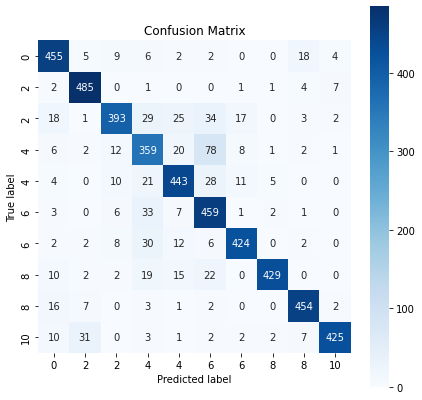

In [98]:
plot_confusion_matrix(resultados['adam']['cm'])

## Decreciente (propio) con Momentum

In [99]:

def Our_Decay():
    modelOurDecay = ResNet56()
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr, momentum=0.9)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=1,scale_mode='decrecimiento')

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler,EPOCHS)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    _, our_decay_acc, our_decay_cm = accuracy(modelOurDecay, test_loader)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs, our_decay_cm

resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * EPOCHS
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * EPOCHS
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0
resultados['our_decay']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))


for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs, our_decay_cm = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs
    resultados['our_decay']['cm'] += our_decay_cm

#Saving results
resultados['our_decay']['name'] = 'Nuestro decreciente con Momentum'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] 
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS
resultados['our_decay']['cm'] = resultados['our_decay']['cm'] / MAX_ITERATIONS

Epoch:0, train cost: 2.328300, val cost: 2.187506, train acc: 0.1713, val acc: 0.205800, total: 50000, lr: 0.090000
Epoch:1, train cost: 1.857053, val cost: 1.681329, train acc: 0.3002, val acc: 0.372400, total: 50000, lr: 0.080000
Epoch:2, train cost: 1.623061, val cost: 1.573309, train acc: 0.3997, val acc: 0.414200, total: 50000, lr: 0.070000
Epoch:3, train cost: 1.430907, val cost: 1.446770, train acc: 0.4711, val acc: 0.459400, total: 50000, lr: 0.060000
Epoch:4, train cost: 1.267682, val cost: 1.201763, train acc: 0.5408, val acc: 0.564600, total: 50000, lr: 0.050000
Epoch:5, train cost: 1.134321, val cost: 1.287370, train acc: 0.5905, val acc: 0.544800, total: 50000, lr: 0.040000
Epoch:6, train cost: 1.029648, val cost: 1.108265, train acc: 0.6315, val acc: 0.606800, total: 50000, lr: 0.030000
Epoch:7, train cost: 0.930117, val cost: 1.003830, train acc: 0.6701, val acc: 0.653400, total: 50000, lr: 0.020000
Epoch:8, train cost: 0.847521, val cost: 0.860494, train acc: 0.7015, va

In [100]:
validate_confusion_matrix(resultados['our_decay']['cm'], class_count)

La matriz de confusión es válida


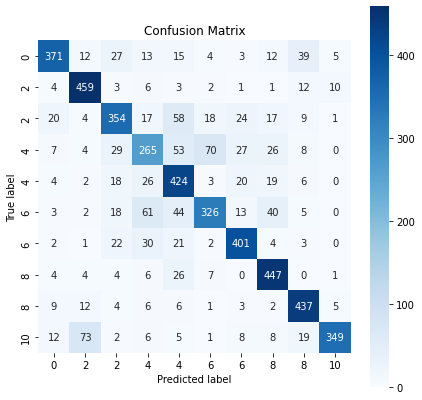

In [101]:
plot_confusion_matrix(resultados['our_decay']['cm'])

## Ciclico Aleatorio extendido con Momentum

In [112]:
def CyclicGDExtended():

    modelRandomCyclic_Extended = ResNet56()
    optimizer = torch.optim.SGD(modelRandomCyclic_Extended.parameters(), lr=lr, momentum=0.9)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='extendido')

    start.record()
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_epochs= train(modelRandomCyclic_Extended, optimizer,scheduler, EPOCHS)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_extended_time = start.elapsed_time(end)

    _, random_cyclic_extended_acc, random_cyclic_extended_cm = accuracy(modelRandomCyclic_Extended, test_loader) 

    return random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs, random_cyclic_extended_cm

resultados['random_cyclic_extended'] = {}
resultados['random_cyclic_extended']['val_acc_list'] = [0] * EPOCHS
resultados['random_cyclic_extended']['test_acc'] = 0
resultados['random_cyclic_extended']['cost'] = [0] * EPOCHS
resultados['random_cyclic_extended']['time'] = 0
resultados['random_cyclic_extended']['epochs'] = 0
resultados['random_cyclic_extended']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs, random_cyclic_extended_cm = CyclicGDExtended()
    resultados['random_cyclic_extended']['val_acc_list'] = SumList(resultados['random_cyclic_extended']['val_acc_list'], random_cyclic_extended_acc_list)
    resultados['random_cyclic_extended']['test_acc'] += random_cyclic_extended_acc
    resultados['random_cyclic_extended']['cost'] = SumList(resultados['random_cyclic_extended']['cost'], random_cyclic_extended_cost_list)
    resultados['random_cyclic_extended']['time'] += random_cyclic_extended_time
    resultados['random_cyclic_extended']['epochs'] += random_cyclic_extended_epochs
    resultados['random_cyclic_extended']['cm'] += random_cyclic_extended_cm

#Saving results
resultados['random_cyclic_extended']['name'] = 'Random Ciclico Extended'
resultados['random_cyclic_extended']['lr'] = random_cyclic_extended_lr_list
resultados['random_cyclic_extended']['test_acc'] = resultados['random_cyclic_extended']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_extended']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['time'] = resultados['random_cyclic_extended']['time']/ MAX_ITERATIONS
resultados['random_cyclic_extended']['epochs'] = resultados['random_cyclic_extended']['epochs'] / MAX_ITERATIONS
resultados['random_cyclic_extended']['cm'] = resultados['random_cyclic_extended']['cm'] / MAX_ITERATIONS

Epoch:0, train cost: 1.849350, val cost: 1.625517, train acc: 0.3120, val acc: 0.392000, total: 50000, lr: 0.066659
Epoch:1, train cost: 1.417403, val cost: 1.266206, train acc: 0.4794, val acc: 0.557400, total: 50000, lr: 0.095523
Epoch:2, train cost: 1.172260, val cost: 1.288375, train acc: 0.5797, val acc: 0.563600, total: 50000, lr: 0.097351
Epoch:3, train cost: 0.948195, val cost: 0.987435, train acc: 0.6637, val acc: 0.666600, total: 50000, lr: 0.098566
Epoch:4, train cost: 0.800521, val cost: 0.838725, train acc: 0.7196, val acc: 0.708800, total: 50000, lr: 0.081879
Epoch:5, train cost: 0.668134, val cost: 0.728912, train acc: 0.7689, val acc: 0.756800, total: 50000, lr: 0.035002
Epoch:6, train cost: 0.542381, val cost: 0.602348, train acc: 0.8110, val acc: 0.789600, total: 50000, lr: 0.012063
Epoch:7, train cost: 0.464957, val cost: 0.514845, train acc: 0.8381, val acc: 0.823200, total: 50000, lr: 0.010388
Epoch:8, train cost: 0.438705, val cost: 0.508392, train acc: 0.8485, va

In [113]:
validate_confusion_matrix(resultados['random_cyclic_extended']['cm'], class_count)

La matriz de confusión es válida


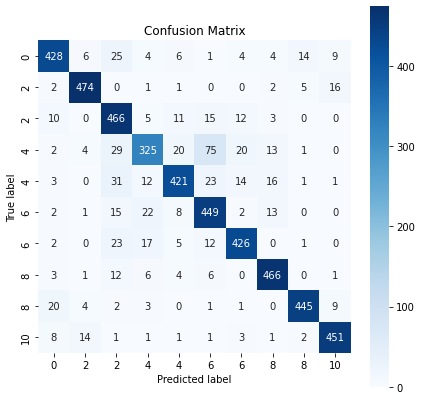

In [114]:
plot_confusion_matrix(resultados['random_cyclic_extended']['cm'])

# Resultados

In [115]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [116]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

# Transformacion a segundos por epoch
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

### Velocidad de convergencia basado en epochs

In [117]:
resultados_df[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_8840\1767391596.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
Adam,0.000000,2650817.000000
Nuestro decreciente con Momentum,0.000000,2544740.750000
Random Ciclico Extended,0.000000,2508726.500000


### Curvas de aprendizaje

In [118]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_8840\4194298493.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
Random Ciclico Extended,86.84%,2508726.500000,87.02%,0.000000
Adam,86.26%,2650817.000000,86.52%,0.000000
Nuestro decreciente con Momentum,76.74%,2544740.750000,76.66%,0.000000


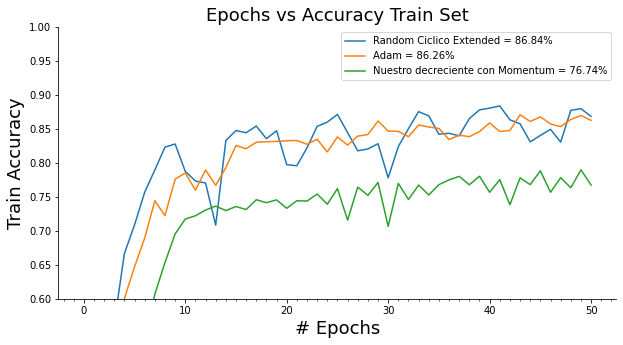

In [119]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.6, 1])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

### Curvas de aprendizaje: pérdida en la función de costo

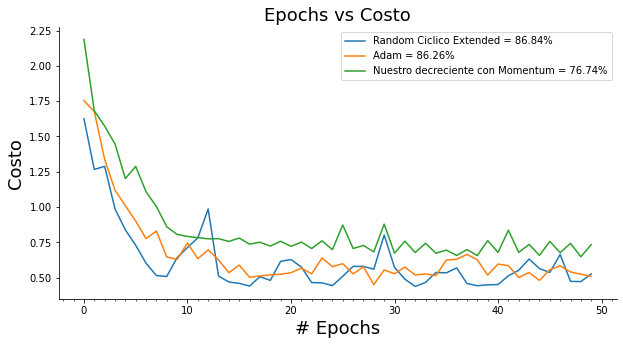

In [120]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name} = {acc}'.format(name= resultados_df.loc[k1,'name'],
                                       acc = resultados_df.loc[k1,'val_acc']))

plt.title('Epochs vs Costo', fontsize = 18)


ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [121]:
from datetime import datetime
import os.path

#Get time
now = datetime.now()
#Format DateTime
date_time = now.strftime("%m_%d_%Y-%H_%M")

#Create Path for save Results
file_name = os.path.join('Resnet_new', f'Experimento3[{date_time}].xlsx')

resultados_df.to_excel(file_name, index = False)